In [1]:
import efel

from bluepy.v2 import Simulation

from bluepy.v2 import Circuit
from bluepy.v2 import Cell
from bluepy.v2.enums import Synapse

from os import path

import pandas as pd

import numpy as np

from matplotlib import pyplot as plt
import pickle


In [2]:
##### INPUT FILES ##### 

# met_gen_nostim

um_file_name = '/gpfs/bbp.cscs.ch/project/proj34/scratch/polina/um_withMet_gen_nostim_2020112216.txt' # um with gen met: met_gen_nostim : Calv no layers

# python getAllEfel.py /gpfs/bbp.cscs.ch/project/proj34/sh_ngvm/column/met_gen_nostim/BlueConfig ../out_data/efel_met_gen_nostim.pickle
feature_values_file_name1 = '/gpfs/bbp.cscs.ch/project/proj34/metabolismndam/out_data/efel_met_gen_nostim_f1.pickle'
feature_values_file_name2 = '/gpfs/bbp.cscs.ch/project/proj34/metabolismndam/out_data/efel_met_gen_nostim_f2.pickle'

BlueConfig_file_name = '/gpfs/bbp.cscs.ch/project/proj34/sh_ngvm/column/met_gen_nostim/BlueConfig'

#########
circuit_config_file_name = '/gpfs/bbp.cscs.ch/project/proj64/circuits/O1.v6a/20181207/CircuitConfig'

In [3]:
mean_freq = 'mean_frequency'

#features from Michiel

efel_feats1 = ['AP_amplitude','AP_height','AP_duration_half_width','mean_frequency',
 'AHP_depth','AHP_time_from_peak','voltage_base',
 'time_to_first_spike','time_to_last_spike','ISI_CV','ISI_log_slope',
 'inv_first_ISI',
 'inv_second_ISI',
 'inv_third_ISI', 
 'inv_fourth_ISI',
 'inv_fifth_ISI',
 'inv_last_ISI'
]

efel_feats2 = ['AHP_depth_abs', 'Spikecount','amp_drop_first_last','depolarized_base','irregularity_index', 'max_amp_difference','maximum_voltage','mean_AP_amplitude','peak_voltage','spike_half_width']

efel_feats = efel.getFeatureNames()

#np.setdiff1d(efel_feats,efel_feats1)

current = ['current'] # for ATP prediction

np.setdiff1d(efel_feats,efel_feats1+efel_feats2)

array(['AHP1_depth_from_peak', 'AHP2_depth_from_peak',
       'AHP_depth_abs_slow', 'AHP_depth_diff', 'AHP_depth_from_peak',
       'AHP_slow_time', 'AP1_amp', 'AP1_begin_voltage', 'AP1_begin_width',
       'AP1_peak', 'AP1_width', 'AP2_AP1_begin_width_diff',
       'AP2_AP1_diff', 'AP2_AP1_peak_diff', 'AP2_amp',
       'AP2_begin_voltage', 'AP2_begin_width', 'AP2_peak', 'AP2_width',
       'AP_amplitude_change', 'AP_amplitude_diff',
       'AP_amplitude_from_voltagebase', 'AP_begin_indices',
       'AP_begin_time', 'AP_begin_voltage', 'AP_begin_width',
       'AP_duration', 'AP_duration_change',
       'AP_duration_half_width_change', 'AP_end_indices',
       'AP_fall_indices', 'AP_fall_rate', 'AP_fall_rate_change',
       'AP_fall_time', 'AP_phaseslope', 'AP_phaseslope_AIS',
       'AP_rise_indices', 'AP_rise_rate', 'AP_rise_rate_change',
       'AP_rise_time', 'AP_width', 'APlast_amp', 'APlast_width',
       'BAC_maximum_voltage', 'BAC_width', 'BPAPAmplitudeLoc1',
       'BPAPAmplit

In [4]:
um = pd.read_csv(um_file_name,header=None)

um_colnames = ["c_gid","mpi_rank","idxm","VNeu0", "m0", "h0", "n0", "Conc_Cl_out", "Conc_Cl_in", "Na0in", "K0out", "Glc_b", "Lac_b", "O2_b", "q", "Glc_ecs", "Lac_ecs", "O2_ecs", "O2_n", "O2_a", "Glc_n", "Glc_a", "Lac_n", "Lac_a", "Pyr_n", "Pyr_a", "PCr_n", "PCr_a", "Cr_n", "Cr_a", "ATP_n", "ATP_a", "ADP_n", "ADP_a", "NADH_n", "NADH_a", "NAD_n", "NAD_a", "ksi","ksi_ephys"]
print(len(um_colnames))

um.columns =  um_colnames

um = um.add_prefix('with_met_')


um = um.rename(columns={"with_met_c_gid":"c_gid",
                        "with_met_mpi_rank":"mpi_rank",
                        "with_met_idxm":"idxm"})

um.index = um['c_gid']

um_main = um[['c_gid','idxm','with_met_ATP_n']].copy()
print(len(um_main))

um_main = um_main.loc[um_main['with_met_ATP_n'] != " nan",:]

print(len(um_main))

um_main['with_met_ATP_n'] = um_main['with_met_ATP_n'].astype(float)

um_main = um_main.reset_index(drop=True)

um_main_g = um_main[['c_gid','with_met_ATP_n']].groupby('c_gid').mean()

um_main_g = um_main_g.reset_index()



40
114590
114547


In [5]:
np.max(um_main.idxm.unique())

4

In [6]:
um_idxm_stats = um_main[['c_gid','idxm']].groupby('c_gid').max()

In [7]:
um_idxm_stats[um_idxm_stats['idxm']!=np.max(um_main.idxm.unique())].index.to_list()

[32101.0,
 119772.0,
 124309.0,
 141376.0,
 150010.0,
 150147.0,
 152346.0,
 154332.0,
 155049.0,
 157742.0,
 158674.0,
 158705.0,
 159320.0,
 160872.0]

In [8]:
um_main = um_main.loc[~um_main['c_gid'].isin(um_idxm_stats[um_idxm_stats['idxm']!=4].index.to_list())]

In [9]:
um_diff = {}

for idx,gid in enumerate(um_main['c_gid'].unique()):
    um_diff[gid] = ( (um_main.loc[(um_main['c_gid']==gid)&(um_main['idxm']==0),'with_met_ATP_n'].values[0] - um_main.loc[(um_main['c_gid']==gid)&(um_main['idxm']==1),'with_met_ATP_n'].values[0]) +
                    (um_main.loc[(um_main['c_gid']==gid)&(um_main['idxm']==1),'with_met_ATP_n'].values[0] - um_main.loc[(um_main['c_gid']==gid)&(um_main['idxm']==2),'with_met_ATP_n'].values[0]) +
                    (um_main.loc[(um_main['c_gid']==gid)&(um_main['idxm']==2),'with_met_ATP_n'].values[0] - um_main.loc[(um_main['c_gid']==gid)&(um_main['idxm']==3),'with_met_ATP_n'].values[0]) +
                    (um_main.loc[(um_main['c_gid']==gid)&(um_main['idxm']==3),'with_met_ATP_n'].values[0] - um_main.loc[(um_main['c_gid']==gid)&(um_main['idxm']==4),'with_met_ATP_n'].values[0]) )/4
    
    if (idx%1000 ==0):
        print(idx)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000


In [10]:
c = Circuit(circuit_config_file_name)
mc2_cells = c.cells.get({'$target': 'mc2_Column'}, properties=[Cell.X, Cell.Y, Cell.Z,Cell.SYNAPSE_CLASS,Cell.ETYPE,Cell.MTYPE,Cell.ME_COMBO,Cell.LAYER])

In [12]:
with open(feature_values_file_name1, 'rb') as handle:
    feature_values = pickle.load(handle)

with open(feature_values_file_name2, 'rb') as handle:
    feature_values2 = pickle.load(handle)

fr1 = pd.DataFrame(feature_values)
fr2 = pd.DataFrame(feature_values2)

fr = pd.concat([fr1,fr2])

print((len(fr1)+len(fr2))/len(fr))

frt = fr.transpose()

frt = frt.reset_index()

frt = frt.rename(columns = {'index':'c_gid'})

frt['c_gid']=frt['c_gid'].astype(int)

frt.head()

In [13]:
um_diff1  = {int(k):v for k,v in um_diff.items()}

In [14]:
um_diff_df = pd.DataFrame.from_dict(um_diff1,orient='index',columns=['dATPfromum'])
um_diff_df = um_diff_df.reset_index()

um_diff_df = um_diff_df.rename(columns={'index':'c_gid'})

um_diff_df.head()

,c_gid,dATPfromum
0,823,0.094146
1,500,0.108286
2,4626,0.095082
3,519,0.092381
4,15245,0.092298


In [15]:
um_diff_df['c_gid']=um_diff_df['c_gid'].astype(int)


um_main_g['c_gid']=um_main_g['c_gid'].astype(int)




combo1 = pd.merge(um_main_g, frt, left_on='c_gid',right_on='c_gid',how="inner")
combo = pd.merge(um_diff_df, combo1, left_on='c_gid',right_on='c_gid',how="inner")



combo.index = combo['c_gid']
combo = combo.drop(columns='c_gid')

combo_feat = pd.merge(mc2_cells, combo, left_index=True,right_index=True, how='inner') # or onepercent instead of mc2_cells

combo_feat['with_met_ATP_n'] = combo_feat['with_met_ATP_n'].astype(float)

combo_feat.head()

,x,y,z,synapse_class,etype,mtype,me_combo,layer,dATPfromum,with_met_ATP_n,...,inv_last_ISI,AHP_depth_abs,Spikecount,amp_drop_first_last,irregularity_index,max_amp_difference,maximum_voltage,mean_AP_amplitude,peak_voltage,spike_half_width
103,471.359882,1936.803487,520.632076,INH,cNAC,L1_DAC,cNAC_L23NGC_L1_DAC_1_sm080625a1-6_idD_-_Scale_...,1,0.196719,0.577708,...,0.000000,-80.858009,1.0,NaN,NaN,NaN,7.188100,68.420445,7.188100,1.245689
132,448.371904,1985.349169,674.042436,INH,bNAC,L1_DAC,bNAC_L23NGC_L1_DAC_1_sm080930a1-5_idC_-_Scale_...,1,0.217863,0.724350,...,2.531005,-84.957343,16.0,-0.494296,52.292857,1.845237,7.979539,68.362913,6.762566,0.728954
197,551.561921,1922.114548,520.593832,INH,cNAC,L1_DAC,cNAC_L6NGC_L1_DAC_1_sm080625a1-6_idD_-_Scale_x...,1,0.109621,0.404094,...,3.463803,-82.744601,18.0,-0.979687,200.187500,2.628829,-4.128190,56.429091,-5.856745,0.953341
249,185.129482,1994.186369,470.053100,INH,cNAC,L1_DAC,cNAC_L6NGC_L1_DAC_1_sm120429_2photon_a1-3_idA_...,1,0.097981,0.377599,...,21.598272,-74.526300,117.0,9.330566,8.462609,1.704559,-7.417548,47.562941,-13.836338,1.233572
300,274.850295,1706.944428,475.788911,EXC,cADpyr,L3_TPC:A,cADpyr_L3TPC_L3_TPC:A_3_dend-C170897A-P2_axon-...,3,0.098628,0.380473,...,9.090909,-64.975347,60.0,11.603920,33.813793,6.398071,53.863174,99.511557,45.661063,0.575529


In [16]:
# gen met thalam stim

sim = Simulation(BlueConfig_file_name)
report = sim.report('ATPConcAllCmps', source='h5')
atp = report.get()
atp = atp.reset_index()


atp_t = atp.transpose()

atp_t.columns = atp_t.loc['time',:]

atp_t.drop(atp_t.index[0], inplace=True)



#atp_t['mean'] = atp_t.mean(axis=1)

#atp_t['diff'] =  atp_t[0.0] - atp_t[4999.0]



atp_t['diff'] =  ((atp_t[0.0] - atp_t[999.0]) + (atp_t[1000.0] - atp_t[1999.0]) + (atp_t[2000.0] - atp_t[2999.0])+ (atp_t[3000.0] - atp_t[3999.0]) + (atp_t[4000.0] - atp_t[4999.0]))/5



#atp_t['diff'] = atp_t[0.0] - atp_t[999.0]

#atp_t['diff'] =  ((atp_t[0.0] - atp_t[999.0])/np.nanmean(atp_t[0:999]) +
#                  (atp_t[1000.0] - atp_t[1999.0])/np.nanmean(atp_t[1000:1999]) +
#                  (atp_t[2000.0] - atp_t[2999.0])/np.nanmean(atp_t[2000:2999]) +
#                  (atp_t[3000.0] - atp_t[3999.0])/np.nanmean(atp_t[3000:3999]) +
#                  (atp_t[4000.0] - atp_t[4999.0])/np.nanmean(atp_t[4000:4999]))/5

atp2 = pd.DataFrame(atp_t.loc[:,'diff'])
#atp2 = pd.DataFrame(atp_t.loc[:,['mean','diff']])

print(len(atp2))
atp2 = atp2.loc[~atp2['diff'].isna()]
print(len(atp2))

combo2 = pd.merge(atp2, combo_feat, left_index=True,right_index=True, how='inner')

# mean is mean ATP conc from ndam reports

#combo2 = combo2.rename(columns = {'mean':'meanATPconc'})
combo2 = combo2.rename(columns = {'diff':'deltaATPconc'})

combo2.head()


Have keys ({'FlushBufferScalar'}) that are not defined for section: Run
Ignoring unknown key: 'FlushBufferScalar'


22918
22900


,deltaATPconc,x,y,z,synapse_class,etype,mtype,me_combo,layer,dATPfromum,...,inv_last_ISI,AHP_depth_abs,Spikecount,amp_drop_first_last,irregularity_index,max_amp_difference,maximum_voltage,mean_AP_amplitude,peak_voltage,spike_half_width
103,0.421743,471.359882,1936.803487,520.632076,INH,cNAC,L1_DAC,cNAC_L23NGC_L1_DAC_1_sm080625a1-6_idD_-_Scale_...,1,0.196719,...,0.000000,-80.858009,1.0,NaN,NaN,NaN,7.188100,68.420445,7.188100,1.245689
132,0.420270,448.371904,1985.349169,674.042436,INH,bNAC,L1_DAC,bNAC_L23NGC_L1_DAC_1_sm080930a1-5_idC_-_Scale_...,1,0.217863,...,2.531005,-84.957343,16.0,-0.494296,52.292857,1.845237,7.979539,68.362913,6.762566,0.728954
197,0.332333,551.561921,1922.114548,520.593832,INH,cNAC,L1_DAC,cNAC_L6NGC_L1_DAC_1_sm080625a1-6_idD_-_Scale_x...,1,0.109621,...,3.463803,-82.744601,18.0,-0.979687,200.187500,2.628829,-4.128190,56.429091,-5.856745,0.953341
249,0.477410,185.129482,1994.186369,470.053100,INH,cNAC,L1_DAC,cNAC_L6NGC_L1_DAC_1_sm120429_2photon_a1-3_idA_...,1,0.097981,...,21.598272,-74.526300,117.0,9.330566,8.462609,1.704559,-7.417548,47.562941,-13.836338,1.233572
300,0.469420,274.850295,1706.944428,475.788911,EXC,cADpyr,L3_TPC:A,cADpyr_L3TPC_L3_TPC:A_3_dend-C170897A-P2_axon-...,3,0.098628,...,9.090909,-64.975347,60.0,11.603920,33.813793,6.398071,53.863174,99.511557,45.661063,0.575529


In [17]:
len(combo2)

2290

In [29]:
# script to calc efel features /gpfs/bbp.cscs.ch/project/proj34/metabolismndam/utils/getAllEfel.py

#!pip install scikit-learn

In [20]:
from sklearn.linear_model import LinearRegression

In [18]:
print(len(combo2))
combo2 = combo2.dropna()
print(len(combo2))

2290
2174


In [21]:
#Multiple Linear Regression

model = LinearRegression().fit(combo2.loc[:,['layer','AP_amplitude', 'AP_height',
       'AP_duration_half_width', 'mean_frequency', 'AHP_depth',
       'AHP_time_from_peak', 'voltage_base', 'time_to_first_spike',
       'time_to_last_spike', 'ISI_CV', 'ISI_log_slope', 'inv_first_ISI',
       'inv_second_ISI', 'inv_third_ISI', 'inv_fourth_ISI', 'inv_fifth_ISI',
       'inv_last_ISI', 'AHP_depth_abs', 'Spikecount', 'amp_drop_first_last',
       'irregularity_index', 'max_amp_difference', 'maximum_voltage',
       'mean_AP_amplitude', 'peak_voltage', 'spike_half_width']], combo2.dATPfromum)

In [22]:
r_sq = model.score(combo2.loc[:,['layer','AP_amplitude', 'AP_height',
       'AP_duration_half_width', 'mean_frequency', 'AHP_depth',
       'AHP_time_from_peak', 'voltage_base', 'time_to_first_spike',
       'time_to_last_spike', 'ISI_CV', 'ISI_log_slope', 'inv_first_ISI',
       'inv_second_ISI', 'inv_third_ISI', 'inv_fourth_ISI', 'inv_fifth_ISI',
       'inv_last_ISI', 'AHP_depth_abs', 'Spikecount', 'amp_drop_first_last',
       'irregularity_index', 'max_amp_difference', 'maximum_voltage',
       'mean_AP_amplitude', 'peak_voltage', 'spike_half_width']], combo2.dATPfromum)

print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)

coefficient of determination: 0.5121162818363163
intercept: -1.9805698852171412
slope: [ 7.55332144e-03 -3.55234405e-04  2.17350558e-03  1.52612088e-04
  2.42343958e-03  1.02391326e-02  2.35588917e-03 -2.11213311e-02
 -2.70007229e-05  5.75157480e-06  1.00897919e-03  5.50372618e-03
 -5.41621484e-05 -2.27661734e-04  1.71566186e-04 -9.40105702e-05
  1.88901505e-05 -8.86027222e-05 -1.08821985e-02 -3.56655459e-04
 -3.42663162e-05  6.95830122e-07  7.49077024e-04 -3.53484184e-03
 -3.55234405e-04  2.17350558e-03  1.09419363e-04]


In [ ]:
#now can use this model to predict delta ATP in other sim runs by efel features

#y_pred = model.predict(x2)
#print('predicted response:', y_pred, sep='\n')

In [23]:
combo2.head()

,deltaATPconc,x,y,z,synapse_class,etype,mtype,me_combo,layer,dATPfromum,...,inv_last_ISI,AHP_depth_abs,Spikecount,amp_drop_first_last,irregularity_index,max_amp_difference,maximum_voltage,mean_AP_amplitude,peak_voltage,spike_half_width
132,0.420270,448.371904,1985.349169,674.042436,INH,bNAC,L1_DAC,bNAC_L23NGC_L1_DAC_1_sm080930a1-5_idC_-_Scale_...,1,0.217863,...,2.531005,-84.957343,16.0,-0.494296,52.292857,1.845237,7.979539,68.362913,6.762566,0.728954
197,0.332333,551.561921,1922.114548,520.593832,INH,cNAC,L1_DAC,cNAC_L6NGC_L1_DAC_1_sm080625a1-6_idD_-_Scale_x...,1,0.109621,...,3.463803,-82.744601,18.0,-0.979687,200.187500,2.628829,-4.128190,56.429091,-5.856745,0.953341
249,0.477410,185.129482,1994.186369,470.053100,INH,cNAC,L1_DAC,cNAC_L6NGC_L1_DAC_1_sm120429_2photon_a1-3_idA_...,1,0.097981,...,21.598272,-74.526300,117.0,9.330566,8.462609,1.704559,-7.417548,47.562941,-13.836338,1.233572
300,0.469420,274.850295,1706.944428,475.788911,EXC,cADpyr,L3_TPC:A,cADpyr_L3TPC_L3_TPC:A_3_dend-C170897A-P2_axon-...,3,0.098628,...,9.090909,-64.975347,60.0,11.603920,33.813793,6.398071,53.863174,99.511557,45.661063,0.575529
313,0.469445,486.472734,1623.650612,715.802817,EXC,cADpyr,L3_TPC:A,cADpyr_L3TPC_L3_TPC:A_3_dend-sm100506a1-4_idE_...,3,0.093514,...,26.385224,-65.774719,95.0,17.021164,12.426882,8.322029,55.291916,96.173955,43.769515,0.575886


In [24]:
combo2.columns

Index(['deltaATPconc', 'x', 'y', 'z', 'synapse_class', 'etype', 'mtype',
       'me_combo', 'layer', 'dATPfromum', 'with_met_ATP_n', 'AP_amplitude',
       'AP_height', 'AP_duration_half_width', 'mean_frequency', 'AHP_depth',
       'AHP_time_from_peak', 'voltage_base', 'time_to_first_spike',
       'time_to_last_spike', 'ISI_CV', 'ISI_log_slope', 'inv_first_ISI',
       'inv_second_ISI', 'inv_third_ISI', 'inv_fourth_ISI', 'inv_fifth_ISI',
       'inv_last_ISI', 'AHP_depth_abs', 'Spikecount', 'amp_drop_first_last',
       'irregularity_index', 'max_amp_difference', 'maximum_voltage',
       'mean_AP_amplitude', 'peak_voltage', 'spike_half_width'],
      dtype='object')

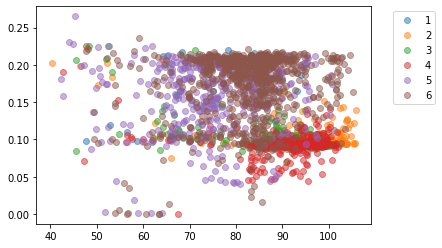

In [27]:
groups = combo2.loc[combo2['mean_frequency']<100,:].groupby('layer')

fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

for name, group in groups:
    ax.plot(group['AP_amplitude'], group['dATPfromum'].abs(), marker='.', linestyle='', ms=12, label=name, alpha=0.5)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()
